In [7]:
import pandas as pd
import nltk
from pyvi import ViTokenizer
import ast
import string
import sys
import os
import glob
import gensim
from sklearn.metrics.pairwise import cosine_similarity
import collections
import seaborn as sns, numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
sns.set(); np.random.seed(0)

In [8]:
import sys
sys.path.insert(0, '..')

In [9]:
from src import preprocess
from src.constants import *

In [10]:
# aspects
aspect_path = '../data/features_dien-thoai-may-tinh-bang_affinity_token_set_ratio.csv'
aspect_df = pd.read_csv(aspect_path)
aspect_df.head()

,similar_features
0,"['Chất_liệu Silicone_siêu_bền', 'Chất_liệu sil..."
1,"['Hỗ_trợ 3D , HDCP_Compliant', 'Hỗ_trợ HĐH iOS..."
2,"['Số ngõ ra', 'Số cổng ra', 'Ngõ ra', 'Loại cổ..."
3,"['Tốc_độ đọc', 'Tốc_độ đọc ( Mb )', 'Tốc_độ', ..."
4,"['2 Nano SIM', '2 Sim 2 Sóng', 'Sim 4G nghe và..."


In [11]:
group_aspects = dict()
count_aspect = 0
for index, row in aspect_df.iterrows():
    aspects = set([x.strip("'. ") for x in row["similar_features"][1:-1].split(',') if len(x.strip("'. ")) > 0])
    count_aspect += len(aspects)
    group_aspects[index] = list(aspects)
group_aspects

{0: ['Chất_liệu siêu_bền',
  'Chất_liệu da mềm_mại',
  'Chất_liệu silicone',
  'Chất_liệu aluminium alloy ( nhôm )',
  'Chất_liệu silicone trong_suốt',
  'Chất_liệu sillicon mềm_dẻo',
  'Chất_liệu Silicone siêu mịn',
  'Chất_liệu Metallic_siêu_bền',
  'Chất_liệu silicone siêu mịn',
  'Chất_liệu Silicone_siêu_bền',
  'Chất_liệu silicone dẻo',
  'Chất_liệu composite siêu nhẹ',
  'Chất_liệu silicone siêu_bền',
  'Chất_liệu silicon mềm_dẻo',
  'Chât_liệu',
  'Chất_liệu hợp_kim_xi',
  'Chất_liệu cánh_quạt'],
 1: ['Tổng_đài hỗ_trợ 24/7',
  'Hỗ_trợ đa giao_thức',
  'Hỗ_trợ dòng_điện 5V - 3A',
  'Hỗ_trợ 2 Micro_Sim',
  'Hỗ_trợ Quick Charge 3.0',
  'Hỗ_trợ HĐH iOS',
  'Hỗ_trợ với các HĐH',
  'Hỗ_trợ 3D',
  'Hỗ_trợ loa ngoài',
  'HDCP_Compliant',
  'Hỗ_trợ Ethernet_Channel',
  'Hỗ_trợ HDMI 1.3 b',
  'Hỗ_trợ thẻ tối_đa',
  'Có hỗ_trợ tiếng Việt',
  'Hỗ_trợ mạng 4G / 3G / 2G',
  'Android',
  'Hỗ_trợ video 4K'],
 2: ['Số cổng ra',
  'Số cổng 1',
  'Loại cổng ra',
  'Ngõ ra',
  'Cổng ra',
  'Số cổng

In [12]:
count_aspect

1592

In [13]:
for k in group_aspects.keys():
    aspects = [gensim.utils.simple_preprocess(a) for a in group_aspects[k]]
    group_aspects[k] = aspects
group_aspects[0]

[['chất_liệu', 'siêu_bền'],
 ['chất_liệu', 'da', 'mềm_mại'],
 ['chất_liệu', 'silicone'],
 ['chất_liệu', 'aluminium', 'alloy', 'nhôm'],
 ['chất_liệu', 'silicone', 'trong_suốt'],
 ['chất_liệu', 'sillicon', 'mềm_dẻo'],
 ['chất_liệu', 'silicone', 'siêu', 'mịn'],
 ['chất_liệu'],
 ['chất_liệu', 'silicone', 'siêu', 'mịn'],
 ['chất_liệu'],
 ['chất_liệu', 'silicone', 'dẻo'],
 ['chất_liệu', 'composite', 'siêu', 'nhẹ'],
 ['chất_liệu', 'silicone', 'siêu_bền'],
 ['chất_liệu', 'silicon', 'mềm_dẻo'],
 ['chât_liệu'],
 ['chất_liệu', 'hợp_kim_xi'],
 ['chất_liệu', 'cánh_quạt']]

In [14]:
# comment_path = '../data/ecommerce_sites/tiki_dien-thoai-may-tinh-bang_comments.csv'
comment_path = '../data/ecommerce_sites/tgdd_dtdd_comments.csv'
df = pd.read_csv(comment_path)
df.head()

,product_id,comment_id,title,content,rating,thank_count
0,114111,28525478,NaN,"Thiết kế sang trọng, thời thượng, lên mạng rất...",5,NaN
1,114111,28121299,NaN,Sản phẩm rất là đẹp và sử dụng rất là tốt cho ...,5,NaN
2,114111,28105910,NaN,"San phạm su dung rất tốt, chụp hinh rất đẹp hỗ...",5,NaN
3,114111,28009505,NaN,hay treo home ảo khi dời ứng dụng vào thư mục ...,5,NaN
4,114111,27280935,NaN,mua tại tgdd ngày đầu khởi bán cho đến nay. cả...,5,NaN


In [15]:
df[['product_id', 'comment_id']].groupby(['product_id']).count() \
    .reset_index().sort_values(['comment_id'], ascending=False).head(10)

,product_id,comment_id
14,84798,1851
15,84905,1439
53,103404,1114
97,118143,723
79,112432,545
24,88573,476
133,153953,437
37,91853,361
36,91849,347
114,143465,342


In [16]:
# df.loc[df['product_id'] == product_id]['comment_id']

In [17]:
product_id = 153953
comments = list()
len_comments = list()
for index, row in df[df['product_id'] == product_id].iterrows():
    title = ''
    if pd.isnull(row['title']) is False:
        title = row['title']
    content = ''
    if pd.isnull(row['content']) is False:        
        content = row['content']
    if len(title.strip()) == 0 and len(content.strip()) == 0:
        continue

    comments.append((row['rating'], title + ' . ' + content))
    len_comments.append(len(title + ' . ' + content))
len(comments)

437

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


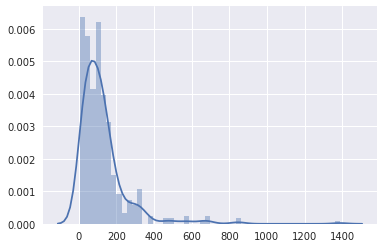

In [18]:
ax = sns.distplot(len_comments)
plt.show() #show the plot

In [19]:
sentences = list()
for comment in comments:
    temp = [s for s in nltk.sent_tokenize(ViTokenizer.tokenize(comment[1])) if len(s) > 1]
    temp = [preprocess.preprocess_sentence(s) for s in temp]
    temp = [gensim.utils.simple_preprocess(s) for s in temp]
    sentences.extend([(comment[0], s)for s in temp])
len(sentences)    

921

In [20]:
import operator
sorted(sentences, key=operator.itemgetter(0), reverse=False)

[(0, ['sao', 'ko', 'mua', 'pro', 'ngon', 'hơn']),
 (0, ['note', 'number_token', 'cũng', 'bị', 'nữa', 'nè', 'bạn', 'ơi']),
 (0, ['huawei', 'tui', 'cũng', 'hay', 'bị', 'ne', 'bạn', 'ơi']),
 (0, ['mình', 'cũng', 'thấy', 'vậy']),
 (0,
  ['màn_hình',
   'là',
   'cường_lực',
   'rồi',
   'nên',
   'ko',
   'cần',
   'dán',
   'đâu',
   'bạn',
   'dán',
   'màn_hình',
   'sẽ',
   'làm',
   'máy',
   'ko',
   'mượt',
   'nữa']),
 (0, ['game', 'gì', 'vậy']),
 (0,
  ['t_chơi',
   'pubg',
   'datetime_token',
   'h_ngốn',
   'number_token',
   'pin_vậy',
   'nhanh',
   'hay',
   'châm']),
 (0,
  ['mới',
   'mua',
   'luôn',
   'nè',
   'ko',
   'biết',
   'ngon',
   'như',
   'lời',
   'bác',
   'ns',
   'ko']),
 (0,
  ['bạn',
   'thử',
   'bật',
   'áp',
   'nct',
   'lên',
   'và',
   'chọn',
   'number_token',
   'bài',
   'hát',
   'cho',
   'chạy',
   'cùng',
   'với',
   'game',
   'xem',
   'nha']),
 (0,
  ['tắt_tiếng',
   'nhạc',
   'cũng',
   'đc',
   'nhưng',
   'phảu',
   'chạy',
   '

In [29]:
# model_dbow = gensim.models.doc2vec.Doc2Vec.load('../model/doc2vec/doc2vec_external_dbow_mean.vec')
# model_dm = gensim.models.doc2vec.Doc2Vec.load('../model/doc2vec/doc2vec_external_dm_mean.vec')
model = gensim.models.doc2vec.Doc2Vec.load('../model/doc2vec/doc2vec_external_dbow_mean.vec')

In [30]:
group_aspect_vectors = dict()
for k in group_aspects.keys():
    group_aspect_vectors[k] = list()
    for aspect in group_aspects[k]:
        group_aspect_vectors[k].append(model.infer_vector(aspect))
# aspect_vectors[0]

In [31]:
group_aspect_result = dict()
for sent_idx, sentence in enumerate(sentences):
    rating = sentence[0]
    words = sentence[1]
    scores = dict()
    inferred_comment_vector = model.infer_vector(words)
    
    for k in group_aspect_vectors.keys():
        aspect_vectors = group_aspect_vectors[k]
        for inferred_aspect_vector in aspect_vectors:
            sim = cosine_similarity(inferred_comment_vector.reshape(1, -1), inferred_aspect_vector.reshape(1, -1))
            if sim >= 0.5:
                if (k in scores.keys() and scores[k] < sim) or (k not in scores.keys()):
                    scores[k] = sim

    # sentence index, aspect index, score
    for group_idx in scores.keys():
        if group_idx in group_aspect_result.keys():
            group_aspect_result[group_idx]['sent_idx'].append(sent_idx)
            group_aspect_result[group_idx]['sim'].append(scores[group_idx])
        else:
            group_aspect_result[group_idx] = dict()
            group_aspect_result[group_idx]['sent_idx'] = [sent_idx]
            group_aspect_result[group_idx]['sim'] = [scores[group_idx]]
    sys.stdout.write('\r')
    sys.stdout.write(str(sent_idx))
    sys.stdout.flush()
sys.stdout.write('\r')

In [25]:
len(group_aspect_result)

154

In [155]:
sorted([s[0][0] for s in group_aspect_result[group_idx]['sim']], reverse=True)

[0.60202307,
 0.57584405,
 0.5665668,
 0.5585932,
 0.55638534,
 0.52634674,
 0.51536494,
 0.5099523,
 0.50948584,
 0.5043056]

In [34]:
# filter_aspect_result = dict()
for group_idx in group_aspect_result.keys():

    sim_sents = zip([s[0][0] for s in group_aspect_result[group_idx]['sim']],
                    [s for s in group_aspect_result[group_idx]['sent_idx']])
    sorted_sim_sents = sorted(sim_sents, key=operator.itemgetter(0), reverse=True)
    
    if len(sorted_sim_sents) > 10:
        print('\ngroup_aspect:',group_aspects[group_idx][:10])
    else:
        print('\ngroup_aspect:', group_aspects[group_idx])
    for idx, (sim, sent_idx) in enumerate(sorted_sim_sents):
        if idx <= 10 and sim >= 0.5:
            print('\tsimilarity: %s, sentence: %s' % (sim, ' '.join(sentences[sent_idx][1])))
            
#     if len(sorted_sim_sents) > 4:
#         print('similarity:', sorted_sim_sents[:4])
#     else:
#         print('similarity:', sorted_sim_sents)
    
    count_by_raing = []
    sents = []
    for sent_idx in group_aspect_result[group_idx]['sent_idx']:
        count_by_raing.append(sentences[sent_idx][0])
        sents.append(' '.join(sentences[sent_idx][1]))
    ratings = collections.Counter(count_by_raing)
    for star in ratings.keys():
        print('%s stars: %s rates' % (star, ratings[star]))
#     print('sent_idx:', sents)
    
#     if np.average(aspect_result[aspect_idx]['sim']) >= 0.7:
#         print('\naspect:', aspects[aspect_idx])
#         print('similarity:', aspect_result[aspect_idx]['sim'])
#         filter_aspect_result[aspect_idx] = aspect_result[aspect_idx].copy()
# print(len(filter_aspect_result))


group_aspect: [['chất_liệu', 'siêu_bền'], ['chất_liệu', 'da', 'mềm_mại'], ['chất_liệu', 'silicone'], ['chất_liệu', 'aluminium', 'alloy', 'nhôm'], ['chất_liệu', 'silicone', 'trong_suốt'], ['chất_liệu', 'sillicon', 'mềm_dẻo'], ['chất_liệu', 'silicone', 'siêu', 'mịn'], ['chất_liệu'], ['chất_liệu', 'silicone', 'siêu', 'mịn'], ['chất_liệu']]
	similarity: 0.7071636, sentence: chơi game mượt
	similarity: 0.7020941, sentence: máy đẹp và mượt
	similarity: 0.6606149, sentence: thật là sao bạn
	similarity: 0.65245754, sentence: haizz
	similarity: 0.64433694, sentence: thật thất_vộng
	similarity: 0.6422724, sentence: cảm_ứng nhạy chạy mượt
	similarity: 0.5986025, sentence: chơi game mượt nhưng nóng rất nhanh
	similarity: 0.59812784, sentence: đừng_vi thương_hiệu mà hãy vì chất_lượng
	similarity: 0.593175, sentence: gps sai_lệch nhiều
	similarity: 0.5779468, sentence: antutu currency_token
	similarity: 0.5723397, sentence: đã mua và trải nghiệm number_token ngày
0 stars: 7 rates
1 stars: 1 rates
3


group_aspect: [['tương_thích', 'với', 'iphone'], ['tương_thích', 'iphone'], ['tương_thích', 'với', 'ios'], ['sim', 'tương_tích'], ['dòng', 'máy', 'tương_thích'], ['tính', 'tương_thích', 'cao'], ['sim', 'tương_thích'], ['tương_thích', 'với', 'bluetooth'], ['ipod'], ['ipad']]
	similarity: 0.6802024, sentence: thời_gian chơi game không như quản_cáo
	similarity: 0.6504554, sentence: cam ổn
	similarity: 0.6340635, sentence: cam ok
	similarity: 0.59079564, sentence: cam tốt
	similarity: 0.5870745, sentence: xiaomi_vô đối
	similarity: 0.55011714, sentence: phải cài mạng bên sim mới đc
	similarity: 0.5465122, sentence: liên_quân free fire max setting
	similarity: 0.5464636, sentence: quá sai làm khi mua con này
	similarity: 0.5163244, sentence: cam ngon
	similarity: 0.5100503, sentence: màu đỏ thì quá đậm
	similarity: 0.50060254, sentence: máy quá ngon trong tầm giá
0 stars: 1 rates
1 stars: 1 rates
2 stars: 1 rates
3 stars: 1 rates
4 stars: 1 rates
5 stars: 6 rates

group_aspect: [['sạc', 'n

	similarity: 0.5418336, sentence: nhưg con này có vẻ ko ổn
	similarity: 0.52086645, sentence: bây_giờ phai chờ bảo_hành tới hai tuần
	similarity: 0.516974, sentence: sạc number_token phút được gần number_token pin
	similarity: 0.5161848, sentence: rất ổn_định và mà khi dùng
	similarity: 0.5099324, sentence: đa cái lol
0 stars: 3 rates
2 stars: 5 rates
3 stars: 1 rates
4 stars: 1 rates
5 stars: 5 rates

group_aspect: [['khuyến_mại', 'gb', 'tháng'], ['băng_thông', 'truyền_tải', 'gbps'], ['phí', 'duy_trì', 'tháng'], ['sim', 'thuận_tiện'], ['khuyến_mại'], ['thời_lượng', 'pin', 'giờ'], ['gb', 'tháng'], ['khuyến_mại'], ['tặng', 'bg', 'mỗi', 'tháng'], ['nhỏ', 'gọn', 'và', 'thuận_tiện']]
	similarity: 0.7938829, sentence: tuột nhiều không bạn
	similarity: 0.70814157, sentence: hỗ_trợ thẻ_nhớ nữa là tốt nhất
	similarity: 0.6938147, sentence: nói_chung mình thấy nó hơn con nova number_token
	similarity: 0.6881832, sentence: tắt_dt đi sẽ không tuột nữa bạn nhé
	similarity: 0.68150854, sentence: xi